In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud
import os
os.makedirs('output/plots', exist_ok=True)
import re
%matplotlib inline
sns.set(style='whitegrid')

In [3]:
# Firs of all I am going to Load the data and quick inspection
 
fn= 'netflix_titles.csv'
df=pd.read_csv(fn)

print('shape:', df.shape)

display(df.head ())
df.info()

print('\nNull counts:')
print(df.isnull().sum().sort_values(ascending=False))
print('\nDuplicate rows:', df.duplicated().sum())
print('\nColumns:', df.columns.tolist())

shape: (8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB

Null counts:
director        2634
country          831
cast             825
date_added        10
rating             4
duration           3
show_id            0
type               0
title              0
release_year       0
listed_in          0
descrip

In [4]:
# Here I will standardize the Column names

df.columns = [c.strip().lower().replace(' ', "_") for c in df.columns]
df.head(1)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."


In [5]:
## I will drop critical-missing rows & fill obvious empties

# will drop subset value
# The code will remove any row from the DataFrame df where either the 'title' column or 
# the 'type' column (or both) contains a missing value. Rows where these specified columns 
# have valid data will be retained.

df = df.dropna(subset=['title', 'type'])

#Since we already saw that director, cast and other columns have missing values, so I will
# add Uknown instead of missing values.

for c in ['director', 'cast']:
    if c in df.columns:
        df[c]=df[c].fillna('Unknown')
print (df[['director', 'type', 'cast']].head())


          director     type                                               cast
0  Kirsten Johnson    Movie                                            Unknown
1          Unknown  TV Show  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...
2  Julien Leclercq  TV Show  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...
3          Unknown  TV Show                                            Unknown
4          Unknown  TV Show  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...


In [6]:
###### I will now start parsing and cleaning key columns

## I will now set the format of the dates of the movies
## Also I will separate the year and month from the dates and will create new columns for that

if 'date_added' in df.columns:
    df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
    df['month_added'] = df['date_added'].dt.month
    df['year_added'] = df['date_added'].dt.year

print(df['date_added'])
print(df['month_added'])
print(df['year_added'])


0      2021-09-25
1      2021-09-24
2      2021-09-24
3      2021-09-24
4      2021-09-24
          ...    
8802   2019-11-20
8803   2019-07-01
8804   2019-11-01
8805   2020-01-11
8806   2019-03-02
Name: date_added, Length: 8807, dtype: datetime64[ns]
0        9.0
1        9.0
2        9.0
3        9.0
4        9.0
        ... 
8802    11.0
8803     7.0
8804    11.0
8805     1.0
8806     3.0
Name: month_added, Length: 8807, dtype: float64
0       2021.0
1       2021.0
2       2021.0
3       2021.0
4       2021.0
         ...  
8802    2019.0
8803    2019.0
8804    2019.0
8805    2020.0
8806    2019.0
Name: year_added, Length: 8807, dtype: float64


In [7]:
## I will make the duration more clear. If the duration has min or season or seasons then it will
## show true or false in a new created columns

    
df['duration'] = df['duration'].astype(str)
df['duration_num'] = df['duration'].str.extract(r'(\d+)').astype(float)
df['is_min'] = df['duration'].str.contains('min', case=False, na=False)
df['is_season'] = df['duration'].str.contains('Season', case=False, na=False) | df['duration'].str.contains('Seasons', case=False, na=False)

df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,month_added,year_added,duration_num,is_min,is_season
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unknown,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",9.0,2021.0,90.0,True,False
1,s2,TV Show,Blood & Water,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",9.0,2021.0,2.0,False,True
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,9.0,2021.0,1.0,False,True
3,s4,TV Show,Jailbirds New Orleans,Unknown,Unknown,NaN,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",9.0,2021.0,1.0,False,True
4,s5,TV Show,Kota Factory,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,9.0,2021.0,2.0,False,True


In [8]:
## Now I will make arrangements sto see the genres of the movies in a clear way.
## I will create a new column where the genres of the movies will be separeated by commas

df['listed_in'] = df['listed_in'].astype(str)
df['genre_list'] = df['listed_in'].str.replace(r',\s*', ',', regex=True).str.split(',')

print(df[['listed_in', 'genre_list']].head())

                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   
3                             Docuseries, Reality TV   
4  International TV Shows, Romantic TV Shows, TV ...   

                                          genre_list  
0                                    [Documentaries]  
1  [International TV Shows, TV Dramas, TV Mysteries]  
2  [Crime TV Shows, International TV Shows, TV Ac...  
3                           [Docuseries, Reality TV]  
4  [International TV Shows, Romantic TV Shows, TV...  


In [9]:
## Now I will do the same for Countries
## It will create new country_list column and will 
## 1. change the word nan in the string (country) to real string with np.nan
## 2. it will fill null values to unknown
## 3. with Regex it will remove extra spaces
## 4. and finally we will have 2 separated columns

df['country'] = df['country'].astype(str)
df['country_list'] = df['country'].replace('nan', np.nan).fillna('Unknown').str.replace(r',\s*', ',', regex=True).str.split(',')

print(df[['country', 'country_list']])

            country     country_list
0     United States  [United States]
1      South Africa   [South Africa]
2               nan        [Unknown]
3               nan        [Unknown]
4             India          [India]
...             ...              ...
8802  United States  [United States]
8803            nan        [Unknown]
8804  United States  [United States]
8805  United States  [United States]
8806          India          [India]

[8807 rows x 2 columns]


In [10]:
#3 I will count the genres and countries in the dataset
## But I will have to make separate dataset for both of them and 
## I will have to count separately because they are in the form of lists
## in the orignal dataset, so I will create separate dateframe just to count the
# values as I dont want to alter the original ones
print(df['genre_list'])
print(df['country_list'])


0                                         [Documentaries]
1       [International TV Shows, TV Dramas, TV Mysteries]
2       [Crime TV Shows, International TV Shows, TV Ac...
3                                [Docuseries, Reality TV]
4       [International TV Shows, Romantic TV Shows, TV...
                              ...                        
8802                     [Cult Movies, Dramas, Thrillers]
8803             [Kids' TV, Korean TV Shows, TV Comedies]
8804                            [Comedies, Horror Movies]
8805                 [Children & Family Movies, Comedies]
8806     [Dramas, International Movies, Music & Musicals]
Name: genre_list, Length: 8807, dtype: object
0       [United States]
1        [South Africa]
2             [Unknown]
3             [Unknown]
4               [India]
             ...       
8802    [United States]
8803          [Unknown]
8804    [United States]
8805    [United States]
8806            [India]
Name: country_list, Length: 8807, dtype: object


In [11]:
# I will also use the explode method which will create list elements in new rows with same ID number

# 6.1 Explode genres
## strip() will remove whitespaces and unwanted elements
df_genres = df.explode('genre_list').copy()
df_genres['genre_list'] = df_genres['genre_list'].str.strip()

# 6.2 Explode countries
df_countries = df.explode('country_list').copy()
df_countries['country_list'] = df_countries['country_list'].str.strip()

# 6.3 Quick counts
print('unique genres:', df_genres['genre_list'].nunique())
print('unique countries:', df_countries['country_list'].nunique())


unique genres: 42
unique countries: 124


In [12]:
## Basic EDA with core numeric Answwers

# 7.1 Movies vs TV Shows
print(df['type'].value_counts())

# 7.2 Top genres (global)
print(df_genres['genre_list'].value_counts().head(15))

# 7.3 Titles per release_year (trend)
counts_by_release = df['release_year'].value_counts().sort_index()
display(counts_by_release.tail(30))  # show recent years

# 7.4 Top production countries
print(df_countries['country_list'].value_counts().head(15))

# 7.5 Top directors
print(df['director'].value_counts().head(20))


type
Movie      6131
TV Show    2676
Name: count, dtype: int64
genre_list
International Movies        2752
Dramas                      2427
Comedies                    1674
International TV Shows      1351
Documentaries                869
Action & Adventure           859
TV Dramas                    763
Independent Movies           756
Children & Family Movies     641
Romantic Movies              616
TV Comedies                  581
Thrillers                    577
Crime TV Shows               470
Kids' TV                     451
Docuseries                   395
Name: count, dtype: int64


release_year
1992      23
1993      28
1994      22
1995      25
1996      24
1997      38
1998      36
1999      39
2000      37
2001      45
2002      51
2003      61
2004      64
2005      80
2006      96
2007      88
2008     136
2009     152
2010     194
2011     185
2012     237
2013     288
2014     352
2015     560
2016     902
2017    1032
2018    1147
2019    1030
2020     953
2021     592
Name: count, dtype: int64

country_list
United States     3690
India             1046
Unknown            831
United Kingdom     806
Canada             445
France             393
Japan              318
Spain              232
South Korea        231
Germany            226
Mexico             169
China              162
Australia          160
Egypt              117
Turkey             113
Name: count, dtype: int64
director
Unknown                   2634
Rajiv Chilaka               19
Raúl Campos, Jan Suter      18
Suhas Kadav                 16
Marcus Raboy                16
Jay Karas                   14
Cathy Garcia-Molina         13
Martin Scorsese             12
Youssef Chahine             12
Jay Chapman                 12
Steven Spielberg            11
Don Michael Paul            10
David Dhawan                 9
Yılmaz Erdoğan               8
Kunle Afolayan               8
Ryan Polito                  8
Lance Bangs                  8
Troy Miller                  8
Fernando Ayllón              8
Quentin Tarantino 

In [13]:
##Feature engineering


# 8.1 is_recent (>=2015)
df['is_recent'] = df['release_year'] >= 2015

# 8.2 num_genres
df['num_genres'] = df['genre_list'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# 8.3 has_known_director
df['has_known_director'] = df['director'] != 'Unknown'


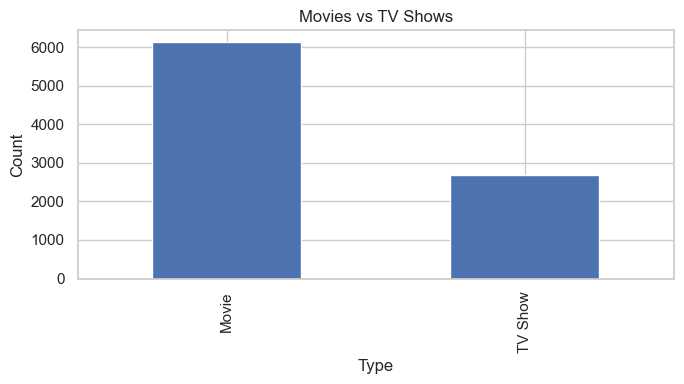

In [14]:
#MAtplotlib Visualizations

## 1 Movies vs Tv Shows Bar
plt.figure(figsize=(7,4))
df['type'].value_counts().plot(kind='bar')
plt.title('Movies vs TV Shows')
plt.xlabel('Type'); plt.ylabel('Count')
plt.tight_layout()
plt.savefig('output/plots/movies_vs_tv.png', dpi=200)
plt.show()


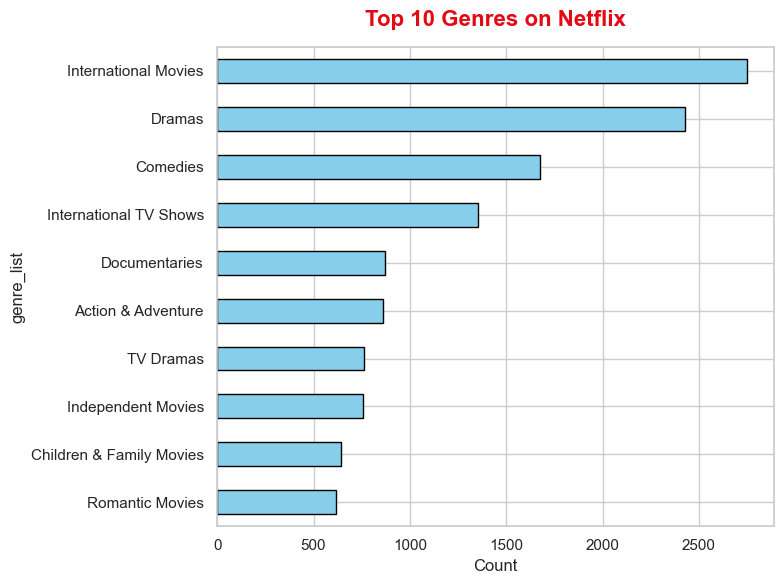

In [15]:
## Top 10 genres (horizontal bar)

plt.figure(figsize=(8,6))
df_genres['genre_list'].value_counts().head(10).sort_values().plot(kind='barh', color='skyblue', edgecolor='black')
plt.title(
    'Top 10 Genres on Netflix',
  
    color='#E50914',        # title color
    fontsize=16,            # title font size
    fontweight='bold',      # make it bold
    pad=15,                 # add space above chart
    loc='center'            # title position (left, center, right)
)

plt.xlabel('Count')
plt.tight_layout()
plt.savefig('output/plots/top10_genres.png', dpi=200)
plt.show()


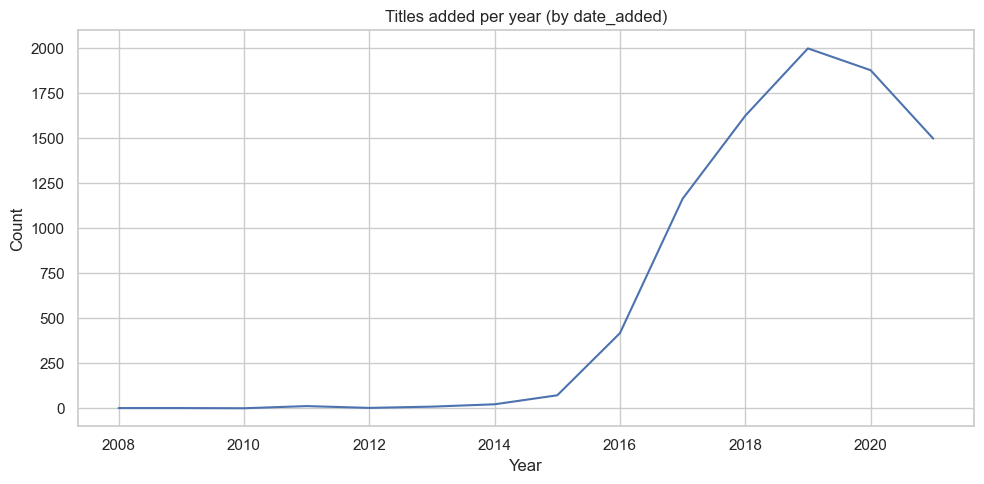

In [16]:
plt.figure(figsize=(10,5))
if df['year_added'].notna().sum() > 0:
    series = df['year_added'].value_counts().sort_index()
    
    ## here we didnt use x and y for axises becasue value_counts already gave us two things one is "years" and other
    ## is "counted values".
    ## TIPS:: whenever we access any column from the data set it gives us series with index
    ### so in the series that we created above to count values, already gave us years as index and counted values
    ### as values. 
    plt.plot(series.index, series.values)
    ### so here in the plot we dont have to mention x and y because plot always takes first argument
    ### as x and second as y. so if when we mentioned index as first and values as second it took them as x and y
    
    plt.title('Titles added per year (by date_added)')
else:
    series = df['release_year'].value_counts().sort_index()
    plt.plot(series.index, series.values)
    plt.title('Titles per release year')
plt.xlabel('Year'); plt.ylabel('Count'); plt.tight_layout()
plt.savefig('output/plots/titles_per_year.png', dpi=200)
plt.show()


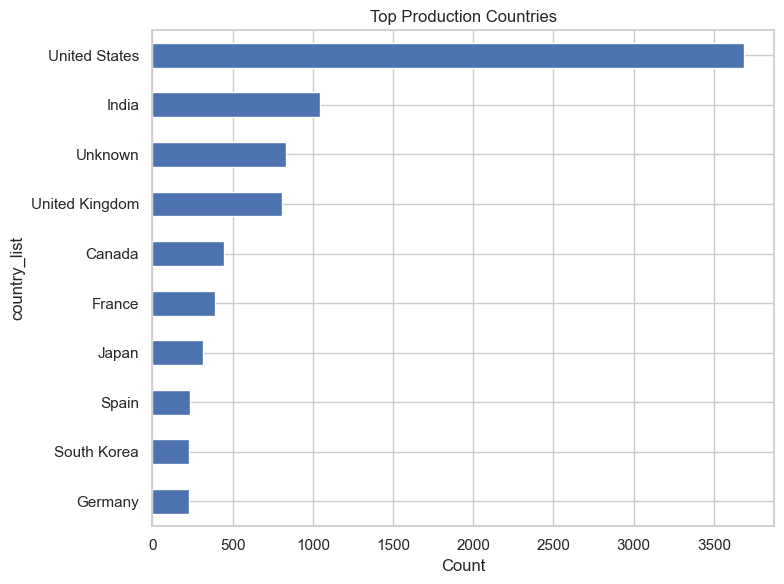

In [17]:
## Top production countries (barh):

plt.figure(figsize=(8,6))
df_countries['country_list'].value_counts().head(10).sort_values().plot(kind='barh')
plt.title('Top Production Countries')
plt.xlabel('Count'); plt.tight_layout()
plt.savefig('output/plots/top_countries.png', dpi=200)
plt.show()


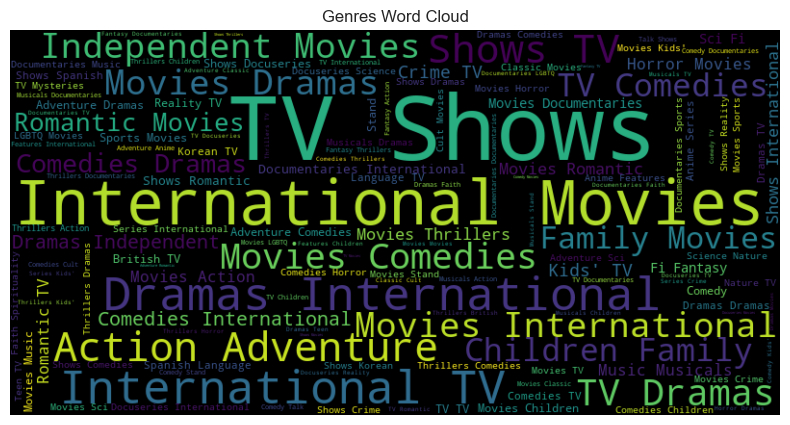

In [20]:
### Now here I am using WordCloud to present our genres in visual form
### The more the number of genres the more the size of the tex is.

## I am converting genres into list with no NaN value, and joinin with with empty space " "
text = ' '.join(df_genres['genre_list'].dropna().astype(str).tolist())
## Here I created wordcloud object with specific size, it acts as an image Generator with the text
wc = WordCloud(width=800, height=400).generate(text)

## Here I used interpolatiion whch simply smoothes our graphic elements.
plt.figure(figsize=(12,5)); plt.imshow(wc, interpolation='bilinear'); plt.axis('off')
plt.title('Genres Word Cloud'); plt.savefig('output/plots/genres_wordcloud.png', dpi=200); plt.show()


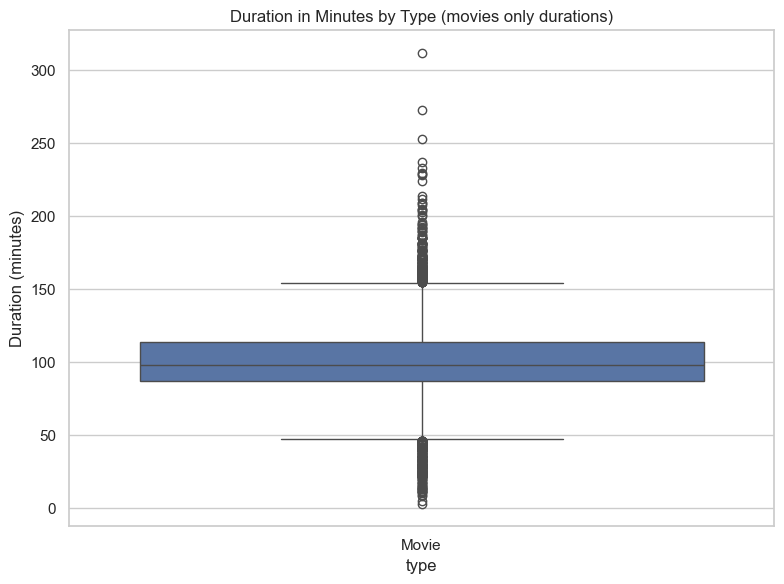

In [ ]:
## Here I used boxplot. 

plt.figure(figsize=(8,6))

## Here I am taking only those rows where duration is measured in minutes not in seasons.
sns.boxplot(x='type', y='duration_num', data=df[df['is_min']==True])
plt.title('Duration in Minutes by Type (movies only durations)')
plt.ylabel('Duration (minutes)')
plt.tight_layout()
plt.savefig('output/plots/duration_boxplot.png', dpi=200)
plt.show()


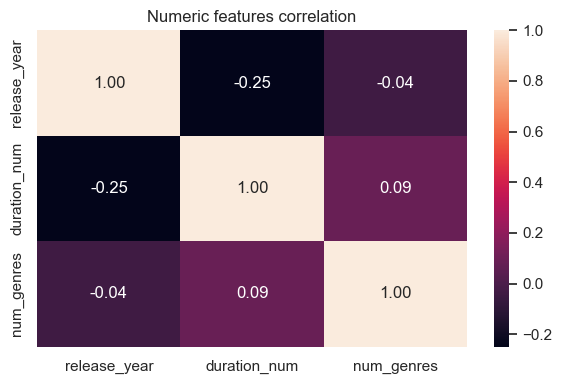

In [27]:
## I am also creating now a HeatMap

num_cols = ['release_year','duration_num','num_genres']
## I took only numeric values because corelation only works with numeric values. 
corr = df[num_cols].corr()
plt.figure(figsize=(6,4)); sns.heatmap(corr, annot=True, fmt='.2f'); plt.title('Numeric features correlation')
plt.tight_layout(); plt.savefig('output/plots/feature_correlation.png', dpi=200); plt.show()


In [28]:
## Analytical Queries 
# Average number of genres per title
print('avg num genres:', df['num_genres'].mean())

# avg duration by type (movies only)
print(df[df['is_min']].groupby('type')['duration_num'].mean())

# Which country produces most TV Shows vs Movies (top 10)
pivot = df_countries.groupby(['country_list','type']).size().unstack(fill_value=0)
display(pivot.sort_values(by=['TV Show'] if 'TV Show' in pivot.columns else pivot.columns.tolist(), ascending=False).head(10))



avg num genres: 2.194050187350971
type
Movie    99.577187
Name: duration_num, dtype: float64


type,Movie,TV Show
country_list,,
United States,2752,938
Unknown,440,391
United Kingdom,534,272
Japan,119,199
South Korea,61,170
Canada,319,126
France,303,90
India,962,84
Taiwan,19,70


In [30]:
## Deploying Machine Learning Model to predict the type from the features...

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack

vec = CountVectorizer(max_features=200)
X_genre = vec.fit_transform(df['listed_in'].fillna(''))
X_num = df[['duration_num','release_year']].fillna(0)
X = hstack([X_genre, X_num.values])
y = (df['type']=='TV Show').astype(int)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train,y_train)
print('accuracy:', clf.score(X_test,y_test))



accuracy: 0.9994324631101021


In [34]:
## Deliverable Checklists


from pathlib import Path
files = {
    'cleaned_csv': Path('output/netflix_cleaned.csv').exists(),
    'plots_dir': Path('output/plots').exists(),
    
}
files


{'cleaned_csv': False, 'plots_dir': True}

In [38]:
## Time to save the Done work


df.to_csv('output/netflix_cleaned.csv', index=False)
print('Saved cleaned CSV -> output/netflix_cleaned.csv')


Saved cleaned CSV -> output/netflix_cleaned.csv
